**Content:** This notebook provides a detailed analysis of the performance of the most successful BTCNN architecture. The primary goal is to understand the causes of its errors and to formulate hypotheses on how it generalizes its predictions.

**Approach:** We begin by introducing various data features, such as whether a plan was part of the training set, whether its structure was seen in the training data, how long it takes to execute, the extent of the model's error on these plans, and so on. We then search for patterns, such as "the error is large when certain features have specific values."

**3D Visualization:** To gain a deeper understanding of why the model makes errors, we also perform visualizations. We identify plans with the most extreme errors, convert them into vector representations using BTCNN, project these vectors onto a two-dimensional plane, and display the top-k nearest points from the training set. This helps us understand why the training data might have been insufficient to accurately predict the label for the query being analyzed.

P.S. The sections `Loading data...`, `Model and Datasets`, and `Helpers` contain a significant amount of code; feel free to skip these sections for simplicity.

In [1]:
import os
import sys

ROOT_PATH = os.path.dirname(os.path.dirname(os.getcwd()))
BTCNN_PATH = os.path.join(ROOT_PATH, "btcnn")
HBO_BENCH_PATH = os.path.join(ROOT_PATH, "hbo_bench")

sys.path.insert(0, ROOT_PATH)
sys.path.insert(0, BTCNN_PATH)
sys.path.insert(0, HBO_BENCH_PATH)

EXPERIMENT_PATH = os.getcwd()
ARTIFACTS_PATH = os.path.join(EXPERIMENT_PATH, "artifacts")

In [2]:
from collections import defaultdict
from json import load, dumps, dump
from itertools import product
from scipy.stats import kendalltau, spearmanr

from tqdm import tqdm
import heapq
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import Tensor
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

from utils import get_logical_tree, get_full_plan, get_selectivities, extract_list_info, preprocess
from oracle import Oracle, OracleRequest, TIMEOUT
from data_config import HINTSETS, DOPS, HINTS, DEFAULT_HINTSET, DEFAULT_DOP
from data_types import ExplainNode
from regressor import BinaryTreeRegressor
from vectorization import extract_vertices_and_edges, ALL_FEATURES
from dataset import WeightedBinaryTreeDataset, weighted_binary_tree_collate
from layers import *

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import umap
from sklearn.decomposition import PCA
from matplotlib.colors import Normalize
from scipy.stats import gaussian_kde
from scipy.interpolate import Rbf
from mpl_toolkits.mplot3d import Axes3D

# Loading data ...

In [4]:
job_oracle = Oracle(f"{HBO_BENCH_PATH}/data/processed/JOB")
sq_oracle = Oracle(f"{HBO_BENCH_PATH}/data/processed/sample_queries")

It seems that the order of queries in `oracle.get_query_names()` is **not fixed** (it depends on OS etc).
So I can't reproduce `*list_info` with the same order I used in the training. Fortunately, I saved the training versions of `*list_info` and I'm going to use them.

P.S. But the data itself is reproducible (the `*list_info` entities from the training and the `*list_info` generated in `_training.ipynb` are the same).

In [5]:
job_list_info = torch.load(f"{ARTIFACTS_PATH}/job_list_info", weights_only=True)
ood_sq_list_info = torch.load(f"{ARTIFACTS_PATH}/ood_sq_list_info", weights_only=True)
id_sq_list_info = torch.load(f"{ARTIFACTS_PATH}/id_sq_list_info", weights_only=True)

In [6]:
job_list_vertices, job_list_edges, job_list_time = [[info[key] for info in job_list_info] for key in ["vertices", "edges", "time"]]        
ood_sq_list_vertices, ood_sq_list_edges, ood_sq_list_time = [[info[key] for info in ood_sq_list_info] for key in ["vertices", "edges", "time"]]
id_sq_list_vertices, id_sq_list_edges, id_sq_list_time = [[info[key] for info in id_sq_list_info] for key in ["vertices", "edges", "time"]]

In [7]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device is {DEVICE}")

device is cpu


In [8]:
# it'll be splitted correctly on train/val datasets` in `load_run`
trainval_dataset = WeightedBinaryTreeDataset(job_list_vertices, job_list_edges, job_list_time, DEVICE)

test_dataset = WeightedBinaryTreeDataset(id_sq_list_vertices, id_sq_list_edges, id_sq_list_time, DEVICE)
ood_dataset = WeightedBinaryTreeDataset(ood_sq_list_vertices, ood_sq_list_edges, ood_sq_list_time, DEVICE)

# Model and Datasets

We'll use in that notebook as a model the most successful architecture - Big BTCNN, Big FCNN, Instance Normalization (see `learning_dynamics.ipynb` for example)

In [9]:
in_channels = len(ALL_FEATURES)
max_length = max([v.shape[0] for v in job_list_vertices + ood_sq_list_vertices + id_sq_list_vertices])
batch_size = 256
lr = 3e-4

In [10]:
def load_ckpt(model, ckpt_path):
    ckpt_state = torch.load(ckpt_path, map_location=DEVICE, weights_only=True)
    model.load_state_dict(ckpt_state['model_state_dict'])
    optimizer = optim.Adam(model.parameters(), lr=lr)
    optimizer.load_state_dict(ckpt_state['optimizer_state_dict'])
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)
    scheduler.load_state_dict(ckpt_state['scheduler_state_dict'])
    start_epoch = ckpt_state["epoch"]    
    return model, optimizer, scheduler, start_epoch

In [11]:
big_btcnn_and_instance_norm = lambda: BinaryTreeSequential(
    BinaryTreeConv(in_channels, 64),
    BinaryTreeActivation(torch.nn.functional.leaky_relu),
    BinaryTreeConv(64, 128),
    BinaryTreeInstanceNorm(128),
    BinaryTreeActivation(torch.nn.functional.leaky_relu),
    BinaryTreeConv(128, 256),
    BinaryTreeInstanceNorm(256),
    BinaryTreeActivation(torch.nn.functional.leaky_relu),
    BinaryTreeConv(256, 512),
    BinaryTreeAdaptivePooling(torch.nn.AdaptiveMaxPool1d(1)),
)

big_fcnn = lambda: torch.nn.Sequential(
    nn.Linear(512, 256),
    nn.LeakyReLU(),
    nn.Linear(256, 128),
    nn.LeakyReLU(),
    nn.Linear(128, 64),
    nn.LeakyReLU(),
    nn.Linear(64, 1),
    nn.Softplus(),
)

In [12]:
def load_run(run):
    generator = torch.Generator().manual_seed(42+run-1)
    train_dataset, val_dataset = torch.utils.data.dataset.random_split(trainval_dataset, [0.8, 0.2], generator=generator)
    train_dataloader, val_dataloader = [
        DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=True,
            collate_fn=lambda el: weighted_binary_tree_collate(el, max_length),
            drop_last=False
        )
        for dataset in [train_dataset, val_dataset]
    ] 

    model, optimizer, scheduler, start_epoch = load_ckpt(
        model=BinaryTreeRegressor(big_btcnn_and_instance_norm(), big_fcnn()),
        ckpt_path=f"{EXPERIMENT_PATH}/models/BigBTCNN_BigFCNN_InstanceNorm_{run}.pth",
    )
    model = model.to(DEVICE)
    return model, train_dataset, val_dataset, train_dataloader, val_dataloader

In [13]:
def get_mse(model, dataset):
    with torch.no_grad():
        running_loss, total_samples = .0, 0
        for v, e, f, t in tqdm(dataset):
            v, e = preprocess(v, e)               
            running_loss += f.to("cpu") * ((model(v.unsqueeze(0), e.unsqueeze(0)).squeeze(0) - t).to("cpu") ** 2).float()
            total_samples += f.to("cpu")
    print(total_samples)
    return (running_loss / total_samples).item() if total_samples else .0

In [14]:
model, train_dataset, val_dataset, train_dataloader, val_dataloader = load_run(1)
print(f"Expected train loss is ~0.06939, real one is {get_mse(model, train_dataset):0.4f}")
print(f"Expected val loss is 27.72444, real one is {get_mse(model, val_dataset):0.4f}")
print("It seems that model loading is sucessfully finished! ")

100%|██████████| 5859/5859 [00:09<00:00, 638.22it/s]


tensor(34870)
Expected train loss is ~0.06939, real one is 0.0657


100%|██████████| 1464/1464 [00:02<00:00, 545.44it/s]

tensor(8522)
Expected val loss is 27.72444, real one is 27.7244
It seems that model loading is sucessfully finished! 


# Helpers

There are just a lot of auxilary functions, that part can be skipped for free.

## DataFrames ...

In [15]:
def get_structure(v, e):
    """cleans cards (and selectivities) and returns hashable repr"""
    scale = 10 ** 3
    v = v.clone()
    v = torch.round(v * scale) / scale
    v[-2:,:] = 0
    return str(v.flatten().tolist()), str(e.flatten().tolist())

In [16]:
def get_tree(v, e):
    """returns hashable repr for v, e"""
    v = v.clone()
    return str(v.flatten().tolist()), str(e.flatten().tolist())

In [17]:
def featurize_dataset(dataset, model, train_structures, train_trees, data_type):
    df = pd.DataFrame(list(dataset), columns=["vertices", "edges", "frequency", "time"])
    df["data_type"] = data_type

    df["time_category"] = "small"
    df.loc[df["time"] > 0.2, "time_category"] = "medium"
    df.loc[df["time"] > 4, "time_category"] = "big"

    df["structure"] = df.apply(lambda row: get_structure(*preprocess(row["vertices"], row["edges"])), axis=1)
    df["structure_category"] = "unseen"
    df.loc[df["structure"].isin(train_structures), "structure_category"] = "seen"

    df["tree"] = df.apply(lambda row: get_tree(*preprocess(row["vertices"], row["edges"])), axis=1)
    df["tree_category"] = "unseen"
    df.loc[df["tree"].isin(train_trees), "tree_category"] = "seen"

    with torch.no_grad():
        df["embedding"] = df.apply(lambda row: model.btcnn(*[t.unsqueeze(0) for t in preprocess(row["vertices"], row["edges"])]).squeeze(0).to("cpu"), axis=1)
        df["prediction"] = df.apply(lambda row: model(*[t.unsqueeze(0) for t in preprocess(row["vertices"], row["edges"])]).to("cpu"), axis=1)        

    for col in ["prediction", "frequency", "time"]:
        df[col] = df.apply(lambda row: row[col].item(), axis=1)

    df["error"] = df["prediction"] - df["time"]
    df["prediction_category"] = "underestimated"
    df.loc[df["error"] > 0, "prediction_category"] = "overestimated"
    
    return df

In [18]:
def filter_df(df, data_type_predicate, structure_predicate="all", tree_predicate="all", time_predicate="all", prediction_predicate="all"):
    idx = (df["data_type"] == data_type_predicate)
    if structure_predicate != "all":
        idx = idx & (df["structure_category"] == structure_predicate)
    if tree_predicate != "all":
        idx = idx & (df["tree_category"] == tree_predicate)        
    if time_predicate != "all":
        idx = idx & (df["time_category"] == time_predicate)
    if prediction_predicate != "all":
        idx = idx & (df["prediction_category"] == prediction_predicate)
    return df.loc[idx]

In [19]:
def load_run_and_get_filtered_df(run, data_type_predicate, structure_predicate, tree_predicate, time_predicate, prediction_predicate):
    model, train_dataset, val_dataset, train_dataloader, val_dataloader = load_run(run)
    train_structures = {get_structure(*preprocess(v, e)) for v, e, *_ in train_dataset}
    train_trees = {get_tree(*preprocess(v, e)) for v, e, *_ in train_dataset}
    datasets = (
        featurize_dataset(dataset, model, train_structures, train_trees, data_type) 
        for dataset, data_type in zip([train_dataset, val_dataset, test_dataset, ood_dataset], ["train", "val", "test", "ood"])
    )
    df = pd.concat(datasets, ignore_index=True)
    return filter_df(df, data_type_predicate, structure_predicate, tree_predicate, time_predicate, prediction_predicate)

## '$\langle \text{vertices}, \text{edges} \rangle \rightarrow \text{something}$'-like maps

In future we will need to know time corresponding particular pair `(vertices, edges)`.

In [20]:
TRAIN_VE_TO_TIMES = defaultdict(set)
TRAIN_VET_TO_QUERY_INFO = defaultdict(set)

for info in job_list_info:
    v, e, t = info["vertices"], info["edges"], info["time"]
    v, e = preprocess(v, e)

    ve = str(v.flatten().tolist()), str(e.flatten().tolist())
    TRAIN_VE_TO_TIMES[ve].add(t)

    vet = str(v.flatten().tolist()), str(e.flatten().tolist()), str(t.flatten().tolist())
    TRAIN_VET_TO_QUERY_INFO[vet].add((info["query_name"], info["hintset"], info["dop"]))

In [21]:
OOD_VE_TO_TIMES = defaultdict(set)
OOD_VET_TO_QUERY_INFO = defaultdict(set)

for info in ood_sq_list_info:
    v, e, t = info["vertices"], info["edges"], info["time"]
    v, e = preprocess(v, e)

    ve = str(v.flatten().tolist()), str(e.flatten().tolist())
    OOD_VE_TO_TIMES[ve].add(t)

    vet = str(v.flatten().tolist()), str(e.flatten().tolist()), str(t.flatten().tolist())
    OOD_VET_TO_QUERY_INFO[vet].add((info["query_name"], info["hintset"], info["dop"]))

In [22]:
JOB_VE_TO_COSTS = defaultdict(list)
JOB_VE_TO_TIMES = defaultdict(list)
for info in job_list_info:
    v, e, t = info["vertices"], info["edges"], info["time"]
    v, e = preprocess(v, e)
    ve = str(v.flatten().tolist()), str(e.flatten().tolist())
    cost = job_oracle.get_cost(OracleRequest(query_name=info["query_name"], hintset=info["hintset"], dop=info["dop"]))
    JOB_VE_TO_COSTS[ve].append(cost)
    JOB_VE_TO_TIMES[ve].append(t.item())

In [23]:
SQ_VE_TO_COSTS = defaultdict(list)
SQ_VE_TO_TIMES = defaultdict(list)
for info in id_sq_list_info + ood_sq_list_info:
    v, e, t = info["vertices"], info["edges"], info["time"]
    v, e = preprocess(v, e)
    ve = str(v.flatten().tolist()), str(e.flatten().tolist())
    cost = sq_oracle.get_cost(OracleRequest(query_name=info["query_name"], hintset=info["hintset"], dop=info["dop"]))
    SQ_VE_TO_COSTS[ve].append(cost)
    SQ_VE_TO_TIMES[ve].append(t.item())

In [24]:
def get_query_info(v, e, ve_map, vet_map, oracle):
    ve = str(v.flatten().tolist()), str(e.flatten().tolist())
    assert ve in ve_map
    res = []
    for t in set(ve_map[ve]):
        vet = str(v.flatten().tolist()), str(e.flatten().tolist()), str(t.flatten().tolist())
        for q_n, hs, dop in vet_map[vet]:
            res.append((q_n, hs, dop, oracle.get_execution_time(OracleRequest(query_name=q_n, hintset=hs, dop=dop))))
    return res

In [25]:
def is_dirty(v, e):
    return TIMEOUT in [t for *_, t in get_query_info(v, e, TRAIN_VE_TO_TIMES, TRAIN_VET_TO_QUERY_INFO, job_oracle)]

## Neighborhoods extracting


In [26]:
def get_neighborhoods(v, e, target_d, debug=False):
    """collects `target_d`-neighborhoods - list its subtrees of height `target_d`"""
    neighborhoods = []

    def recurse(root, cur_d):
        ngbs = [root]
        real_d = -float("inf")
        if cur_d == target_d:
            return 0, ngbs
        for child_d, child_ngbs in [recurse(child.item()-1, cur_d+1) for child in e[root][1:] if child]:
            ngbs += child_ngbs
            real_d = max(real_d, child_d)
        return real_d + 1, ngbs

    neighborhoods = [ngbs for i in range(len(v)) for (max_d, ngbs) in [recurse(i, 0)] if max_d == target_d]
    
    if debug:
        return neighborhoods

    return [torch.stack([v[i] for i in l if i]) for l in neighborhoods]

In [27]:
def get_proportions_of_subtree_matches(dataset, subtrees_height, seen_subtrees):
    matches = []
    for v, e, f, t in dataset:
        per_v_matches = []
        for ngb in get_neighborhoods(v, e, subtrees_height):
            per_v_matches.append(str(ngb.detach().to("cpu").tolist()) in seen_subtrees)
        matches.append(per_v_matches)
    return matches

**Example.** Tree (with taking into account the padding vertex)
```python3
                     1                      
                     |                      
                     2                      
                    /  \                 
                   3   17               
                  / \                       
                 4  16                      
                / \  
               5  15                            
              / \                               
             /   \
            /     \                                  
           6       13                                 
          / \       |                                
         7  12     14                               
        / \                                          
       8  11                                       
      / \                                     
     9  10
```

In [28]:
print("Edges in example tree:")
for p, c1, c2 in job_list_edges[0]:
    if c1 and c2:
        print(f"{p.item()} -> [{c1.item()}, {c2.item()}]")
    elif c1:
        print(f"{p.item()} -> [{c1.item()}]")
    elif c2:
        print(f"{p.item()} -> [{c2.item()}]")

Edges in example tree:
1 -> [2]
2 -> [3, 17]
3 -> [4, 16]
4 -> [5, 15]
5 -> [6, 13]
6 -> [7, 12]
7 -> [8, 11]
8 -> [9, 10]
13 -> [14]


In [29]:
print("Expected results: the only  difference is that there's no 0\nReal results:")
for edge, ngbs in list(zip([x.tolist() for x in job_list_edges[0]], get_neighborhoods(job_list_vertices[0], job_list_edges[0], 1, debug=True)))[:5]:
    print(f"{[el +1 for el in ngbs]} vs {edge}")
print("It works")

Expected results: the only  difference is that there's no 0
Real results:
[1, 2] vs [1, 2, 0]
[2, 3, 17] vs [2, 3, 17]
[3, 4, 16] vs [3, 4, 16]
[4, 5, 15] vs [4, 5, 15]
[5, 6, 13] vs [5, 6, 13]
It works


In [30]:
childs = defaultdict(list)
for parent, child1, child2 in job_list_edges[0]:
    if child1:
        childs[parent.item()-1].append(child1.item()-1)
    if child2:
        childs[parent.item()-1].append(child2.item()-1)        
        
for ngbs_1d, ngbs_2d in list(zip(get_neighborhoods(job_list_vertices[0], job_list_edges[0], 1, debug=True), get_neighborhoods(job_list_vertices[0], job_list_edges[0], 2, debug=True)))[:5]:
    print(f"{[el+1 for el in ngbs_1d]} -> {[el + 1 for el in ngbs_2d]}")
print("Thank God it's working too...")

[1, 2] -> [1, 2, 3, 17]
[2, 3, 17] -> [2, 3, 4, 16, 17]
[3, 4, 16] -> [3, 4, 5, 15, 16]
[4, 5, 15] -> [4, 5, 6, 13, 15]
[5, 6, 13] -> [5, 6, 7, 12, 13, 14]
Thank God it's working too...


In [31]:
def calculate_neighborhoods_dict(n_runs=5):
    res = defaultdict(list)
    for run in range(1, n_runs+1):
        _, train_dataset, val_dataset, *_ = load_run(run)
        for d in range(1, 5):
            train_subtrees = set()
            for v, e, f, t in train_dataset:
                for ngb in get_neighborhoods(v, e, d):
                    subtree = str(ngb.detach().to("cpu").tolist())
                    train_subtrees.add(subtree)

            val_l = get_proportions_of_subtree_matches(val_dataset, d, train_subtrees)
            val_l = [int(el) for subl in val_l for el in subl]
            res[(d, "val")].append(val_l)

            test_l = get_proportions_of_subtree_matches(test_dataset, d, train_subtrees)
            test_l = [int(el) for subl in test_l for el in subl]
            res[(d, "test")].append(test_l)

    return res

In [32]:
def aggregate_neighborhoods_dict(neighborhoods_dict, runs_range, save=True):
    pm = u"\u00B1"
    aggregated_neighborhoods_list = []
    
    for key in neighborhoods_dict:
        val = neighborhoods_dict[key]
        aggregated_neighborhoods_list.append((*key, f"{np.mean([np.mean(val[i-1]) for i in runs_range]):0.3f}{pm}{np.std([np.mean(val[i-1]) for i in runs_range]):0.3f}"))
    aggregated_neighborhoods_df = pd.DataFrame(aggregated_neighborhoods_list, columns=["height", "data_type", "match_probability"])
    
    if save:
        aggregated_neighborhoods_df.to_csv(f"{ARTIFACTS_PATH}/aggregated_neighborhoods_df.csv", index=False)
    
    return aggregated_neighborhoods_df

In [33]:
neighborhoods_dict = calculate_neighborhoods_dict(5)
aggregated_neighborhoods_df = aggregate_neighborhoods_dict(neighborhoods_dict, runs_range=range(1, 5+1), save=True)
# aggregated_neighborhoods_df = pd.read_csv(f"{ARTIFACTS_PATH}/aggregated_neighborhoods_df.csv")

## Stratified Metrics

In [34]:
def calculate_stratified_metrics(n_runs=5):
    res = defaultdict(list)

    for run in range(1, n_runs+1):
        model, train_dataset, val_dataset, train_dataloader, val_dataloader = load_run(run)
        train_structures = {get_structure(*preprocess(v, e)) for v, e, *_ in train_dataset}
        train_trees = {get_tree(*preprocess(v, e)) for v, e, *_ in train_dataset}
        
        datasets = (
            featurize_dataset(dataset, model, train_structures, train_trees, data_type) 
            for dataset, data_type in zip([train_dataset, val_dataset, test_dataset, ood_dataset], ["train", "val", "test", "ood"])
        )
        df = pd.concat(datasets, ignore_index=True)
        
        for data_type_predicate in ["train", "val", "test", "ood"]:
            for structure_predicate in ["all", "seen", "unseen"]:
                for tree_predicate in ["all", "seen", "unseen"]:
                    for time_predicate in ["all", "small", "medium", "big"]:
                        for prediction_predicate in ["all", "underestimated", "overestimated"]:
                            filtered_df = filter_df(df, data_type_predicate, structure_predicate, tree_predicate, time_predicate, prediction_predicate)
                            size = int(filtered_df["frequency"].sum())
                            mse = float((((filtered_df["prediction"] - filtered_df["time"]) ** 2) * filtered_df["frequency"]).sum() / size) if size else .0
                            mape = float((((filtered_df["prediction"] - filtered_df["time"]).abs() / filtered_df["time"]) * filtered_df["frequency"]).sum() / size) if size else .0
                            res[(data_type_predicate, structure_predicate, tree_predicate, time_predicate, prediction_predicate)].append((size, mse, mape))
                            
    return res

In [35]:
def aggregate_metrics_dict(metrics_dict, runs_range, save=True):
    pm = u"\u00B1"
    aggregated_metrics_list = []
    for key in metrics_dict:
        val = metrics_dict[key]
        aggregated_metrics_list.append(
            (
                *key,
                f"{np.mean([val[i-1][0] for i in runs_range]):0.0f}",
                f"{np.mean([val[i-1][1] for i in runs_range]):0.3f}{pm}{np.std([val[i-1][1] for i in runs_range]):0.3f}", 
                f"{np.mean([val[i-1][2] for i in runs_range]):0.3f}{pm}{np.std([val[i-1][2] for i in runs_range]):0.3f}",
            )
        )
    aggregated_metrics_df = pd.DataFrame(
        aggregated_metrics_list, 
        columns=["data_type", "structure_category", "tree_category", "time_category", "prediction_category", "size", "mse", "mape"]
    )
    if save:
        aggregated_metrics_df.to_csv(f"{ARTIFACTS_PATH}/aggregated_metrics_df.csv", index=False)
    return aggregated_metrics_df

In [36]:
def filter_metrics_df(df, allowed_data_type_predicates=None, allowed_structure_predicates=None, allowed_tree_predicates=None, allowed_time_predicates=None, allowed_prediction_predicates=None):
    if allowed_data_type_predicates is None:
        allowed_data_type_predicates = ["train", "val", "test", "ood"]
    if allowed_structure_predicates is None:
        allowed_structure_predicates = ["seen", "unseen", "all"]        
    if allowed_tree_predicates is None:
        allowed_tree_predicates = ["seen", "unseen", "all"]                
    if allowed_time_predicates is None:
        allowed_time_predicates = ["big", "medium", "small", "all"]                
    if allowed_prediction_predicates is None:
        allowed_prediction_predicates = ["underestimated", "overestimated", "all"]                

    idx = (df["data_type"].isin(allowed_data_type_predicates))
    idx = idx & (df["structure_category"].isin(allowed_structure_predicates))
    idx = idx & (df["tree_category"].isin(allowed_tree_predicates))
    idx = idx & (df["time_category"].isin(allowed_time_predicates))
    idx = idx & (df["prediction_category"].isin(allowed_prediction_predicates))

    return df[idx]

In [37]:
metrics_dict = calculate_stratified_metrics(5)
aggregated_metrics_df = aggregate_metrics_dict(metrics_dict, range(1, 5+1), True)
# aggregated_metrics_df = pd.read_csv(f"{ARTIFACTS_PATH}/aggregated_metrics_df.csv")

## Plots

In [38]:
def plot_avg_knn_times(
    support_points,
    figsize=(10, 4),
    label_fontsize=15, 
    linewidth=2, 
    markersize=6, 
    xlabel="k", 
    ylabel="Average time", 
    tick_label_fontsize=15, 
    save_name=None    
):

    sns.set_style("ticks")
    sns.set_palette("deep")
    plt.figure(figsize=figsize)

    all_t, all_f = 0, 0
    res = []
    for d, v, e, f, t, p, emb in sorted(support_points, key=lambda x: x[0]):
        all_f += f
        all_t += f * t
        res.append(all_t / all_f)
    plt.figure(figsize=(10, 4))
    plt.grid(True, which='both', linestyle='--', linewidth=0.2)
    plt.plot(res, marker='o', markersize=markersize, linewidth=linewidth, linestyle='-')
    plt.xlabel("k")
    plt.ylabel("Average Time (sec)")
    if save_name:
        plt.savefig(f"{ARTIFACTS_PATH}/{save_name}", format='svg', dpi=300)
    plt.show() 

In [39]:
def get_k_support_points_and_all_distances(target_embedding, points_dataloader, k):
    top_k = []
    target_embedding = target_embedding.to(DEVICE)
    with torch.no_grad():
        all_distances = []
        for (vertices_batch, edges_batch, f_batch), t_batch in tqdm(points_dataloader):    
            embeddings = model.btcnn(vertices_batch.to(DEVICE), edges_batch.to(DEVICE))
            predicts = model(vertices_batch, edges_batch).squeeze(0)
            distances = torch.cdist(target_embedding.unsqueeze(0), embeddings, p=2).squeeze(0) / torch.norm(target_embedding)
            
            for i in range(predicts.size(0)):
                distance = distances[i].item()
                embedding = embeddings[i]
                all_distances.append(distance)
                v, e, f, t, predict = vertices_batch[i], edges_batch[i], f_batch[i].item(), t_batch[i].item(), predicts[i].item()
                
                # id is here to avoid problems with comparing tensors
                heapq.heappush(top_k, (-distance, id(v), v.to("cpu"), e.to("cpu"), f, t, predict, embedding))
                while len(top_k) > k:
                    heapq.heappop(top_k)
                    
    return [(-d, v, e, f, t, p, emb) for (d, t_id, v, e, f, t, p, emb) in top_k], all_distances

In [40]:
def prepare_args_for_3d_plot(idx, interesting_subdf, n_support_points=100, neighborhoods_size=50, noise_level=0.1):
    target_v, target_e, target_embedding, target_y = interesting_subdf.loc[idx][["vertices", "edges", "embedding", "time"]]

    support_points, all_distances = get_k_support_points_and_all_distances(target_embedding, train_dataloader, k=n_support_points)
    main_X = [emb.to("cpu") for *_, emb in support_points]
    main_y = [t for *_, t, p, emb in support_points]

    all_auxilary_X, all_auxilary_y = [], []
    for d, v, e, *_ in support_points:
        for noise_level_ in [noise_level/10, noise_level, noise_level*10]:
            # data from dataloader is already preprocessed
            auxilary_X, auxilary_y = get_close_embeddings(v, e, model, neighborhoods_size, noise_level_, do_preprocess=False)
            all_auxilary_X += auxilary_X
            all_auxilary_y += auxilary_y

    for noise_level_ in [noise_level/10, noise_level, noise_level*10]:
        auxilary_X, auxilary_y = get_close_embeddings(target_v, target_e, model, neighborhoods_size, noise_level_)
        all_auxilary_X += auxilary_X
        all_auxilary_y += auxilary_y
        
    return main_X, main_y, target_embedding, target_y, all_auxilary_X, all_auxilary_y

In [41]:
def plot_3d_surface(
    main_x, 
    main_y, 
    target_x, 
    target_y, 
    auxilary_x, 
    auxilary_y, 
    figsize=(12, 6), 
    save_name=None, 
    elev=0,
    azim=0, 
    softplus_rescale=False, 
    with_auxilary_points=False, 
    projector=umap.UMAP,
    label_fontsize=12, 
    title_fontsize=14, 
    tick_label_fontsize=10, 
    legend_fontsize=12, 
    cbar_label_fontsize=12,
):
    projector = projector(n_components=2)
    projector.fit(torch.stack(main_x).numpy())
    all_X_2d = projector.transform(torch.stack(main_x + auxilary_x).numpy())
    
    if softplus_rescale:
        main_y = np.log(np.exp(main_y) - 1).tolist()
        target_y = np.log(np.exp(target_y) - 1)
        auxilary_y = np.log(np.exp(auxilary_y) - 1).tolist()

    all_y = main_y + auxilary_y
    main_X_2d = projector.transform(torch.stack(main_x).numpy())
    auxilary_X_2d = projector.transform(torch.stack(auxilary_x).numpy())
    target_x_2d = projector.transform(torch.stack([target_x]).numpy())[0]

    fig = plt.figure(figsize=figsize)
    sns.set_style("ticks")
    sns.set_palette("deep")
    ax = fig.add_subplot(111, projection='3d')
    plt.rcParams['text.usetex'] = False
    
    rbf = Rbf(all_X_2d[:, 0], all_X_2d[:, 1], all_y, function='linear')
    x_ = np.linspace(np.min(all_X_2d[:, 0]), np.max(all_X_2d[:, 0]), 100)
    y_ = np.linspace(np.min(all_X_2d[:, 1]), np.max(all_X_2d[:, 1]), 100)
    X_grid, Y_grid = np.meshgrid(x_, y_)
    Z_grid = rbf(X_grid, Y_grid)
    
    if with_auxilary_points:
        ax.scatter(auxilary_X_2d[:, 0], auxilary_X_2d[:, 1], auxilary_y, color='black', s=1, marker='.', label='Sampled Point', zorder=10, alpha=0.7)
    
    ax.scatter(main_X_2d[:, 0], main_X_2d[:, 1], main_y, color='black', s=75, label='Train Point', marker='.', alpha=1, zorder=-2)
    ax.scatter(target_x_2d[0], target_x_2d[1], target_y, color='red', s=100, marker='o', label='Target Point', zorder=10000, alpha=1, edgecolors='r')

    surface = ax.plot_surface(X_grid, Y_grid, Z_grid, cmap='viridis', edgecolor='none', alpha=0.7, zorder=1)
    cbar = fig.colorbar(surface, ax=ax, shrink=1, aspect=20)
    cbar.set_label('Value', fontsize=cbar_label_fontsize)

    ax.legend(fontsize=legend_fontsize)
    ax.set_xlabel('Component #1', fontsize=label_fontsize,)
    ax.set_ylabel('Component #2', fontsize=label_fontsize)
    ax.set_xticklabels([])
    ax.set_yticklabels([])    

    if save_name:
        plt.savefig(f"{ARTIFACTS_PATH}/{save_name}", format="svg", bbox_inches="tight", dpi=300)
        
    ax.view_init(elev=elev, azim=azim)
    plt.show()

In [42]:
def get_close_embeddings(v, e, model, n=100, noise_level=0.1, do_preprocess=True):
    v, e = preprocess(v, e) if do_preprocess else (v, e)
    v, e, model = v.to("cpu"), e.to("cpu"), model.to("cpu")

    noise = 1 + (torch.randn(n, *v.shape) * noise_level)
    noised_v = noise * v
    noised_e = e.unsqueeze(0).expand((n, -1, -1, -1))
    noised_predictions = model(noised_v, noised_e)
    noised_embeddings = model.btcnn(noised_v, noised_e)
    
    model.to(DEVICE)
    return [emb.detach() for emb in noised_embeddings], [el.item() for el in noised_predictions]

In [43]:
def plot_times(train_times, test_times, val_times, ood_times, fontsize=12, figsize=(12, 6), save_name=None):
    plt.rcParams.update({'font.size': fontsize})
    fig, axs = plt.subplots(4, 1, figsize=figsize, sharex=True, constrained_layout=True) #sharey=True, 

    sns.set_style("ticks")
    sns.set_palette("deep")

    axs[0].set_xscale('log')
    sns.histplot(train_times, kde=True, ax=axs[0])
    axs[0].set_title('Train')
    #axs[0].set_xlabel('Time (sec)', fontsize=fontsize)
    axs[0].set_ylabel('', fontsize=fontsize)
    axs[0].tick_params(axis='x', which='both', labelbottom=True)
    axs[0].set_yticklabels([])

    axs[1].set_xscale('log')
    sns.histplot(val_times, kde=True, ax=axs[1])
    axs[1].set_title('Validation')
    #axs[1].set_xlabel('Time (sec)', fontsize=fontsize)
    axs[1].set_ylabel('', fontsize=fontsize)
    axs[1].tick_params(axis='x', which='both', labelbottom=True)
    axs[1].set_yticklabels([])

    axs[2].set_xscale('log')
    sns.histplot(test_times, kde=True, ax=axs[2])
    axs[2].set_title('Test')
    #axs[2].set_xlabel('Time (sec)', fontsize=fontsize)
    axs[2].set_ylabel('', fontsize=fontsize)
    axs[2].tick_params(axis='x', which='both', labelbottom=True)
    axs[2].set_yticklabels([])

    axs[3].set_xscale('log')
    sns.histplot(ood_times, kde=True, ax=axs[3])
    axs[3].set_title('OOD')
    axs[3].set_xlabel('Time (sec)', fontsize=fontsize)
    axs[3].set_ylabel('', fontsize=fontsize)
    axs[3].tick_params(axis='x', which='both', labelbottom=True, labelsize=fontsize+3)
    axs[3].set_yticklabels([])

    if save_name:
        plt.savefig(f"{ARTIFACTS_PATH}/{save_name}", format="svg", dpi=300)
        
    plt.show()

## Helpers for Ranking Problem

In [44]:
def get_featurized_df(run):
    model, train_dataset, val_dataset, train_dataloader, val_dataloader = load_run(run=run)

    train_structures = {get_structure(*preprocess(v, e)) for v, e, *_ in train_dataset}
    train_trees = {get_tree(*preprocess(v, e)) for v, e, *_ in train_dataset}

    datasets = (
        featurize_dataset(dataset, model, train_structures, train_trees, data_type) 
        for dataset, data_type in zip([train_dataset, val_dataset, test_dataset, ood_dataset], ["train", "val", "test", "ood"])
    )
    return pd.concat(datasets, ignore_index=True)

In [45]:
def get_correlations(df):
    costs_map = JOB_VE_TO_COSTS if "train" in df["data_type"].values or "val" in df["data_type"].values else SQ_VE_TO_COSTS
    times_map = JOB_VE_TO_TIMES if "train" in df["data_type"].values or "val" in df["data_type"].values else SQ_VE_TO_TIMES
    
    costs, times, predictions = [], [], []
    for _, (v, e, p) in df[["vertices", "edges", "prediction"]].iterrows():
        v, e = preprocess(v, e)
        ve = str(v.flatten().tolist()), str(e.flatten().tolist())
        assert ve in costs_map and ve in times_map and len(costs_map[ve]) == len(times_map[ve])
        for cost, time in zip(costs_map[ve], times_map[ve]):
            costs.append(cost), times.append(time), predictions.append(p)    
    return kendalltau(times, costs)[0], kendalltau(times, predictions)[0], spearmanr(times, costs)[0], spearmanr(times, predictions)[0]

In [46]:
def correlations_to_row(correlations):
    pm = u"\u00B1"
    return f"{np.nanmean(correlations):0.3f}{pm}{np.nanstd(correlations):0.3f}"

In [85]:
def calculate_stratified_correlations(n_runs=5):
    res = defaultdict(list)
    for run in range(1, n_runs+1):
        df = get_featurized_df(run=run)
        parameters = product(
            ["train", "val", "test", "ood"],
            ["all", "seen", "unseen"],
            ["all", "seen", "unseen"],
            ["all", "small", "medium", "big"],
            ["all", "underestimated", "overestimated"]
        )  
        for data_type, structure, tree, time, prediction in parameters:
            filtered_df = filter_df(df, **{
                "data_type_predicate": data_type,
                "structure_predicate": structure,
                "tree_predicate": tree,
                "time_predicate": time,
                "prediction_predicate": prediction
            })        
            size = int(filtered_df["frequency"].sum())
            correlations = get_correlations(filtered_df)
            res[(data_type, structure, tree, time, prediction)].append((size, *correlations))                         
    return res

In [48]:
def select_subdf(df, allowed_data_type_predicates=None, allowed_structure_predicates=None, allowed_tree_predicates=None, allowed_time_predicates=None, allowed_prediction_predicates=None):
    if allowed_data_type_predicates is None:
        allowed_data_type_predicates = ["train", "val", "test", "ood"]
    if allowed_structure_predicates is None:
        allowed_structure_predicates = ["seen", "unseen", "all"]        
    if allowed_tree_predicates is None:
        allowed_tree_predicates = ["seen", "unseen", "all"]                
    if allowed_time_predicates is None:
        allowed_time_predicates = ["big", "medium", "small", "all"]                
    if allowed_prediction_predicates is None:
        allowed_prediction_predicates = ["underestimated", "overestimated", "all"]                

    idx = (df["data_type"].isin(allowed_data_type_predicates))
    idx = idx & (df["structure_category"].isin(allowed_structure_predicates))
    idx = idx & (df["tree_category"].isin(allowed_tree_predicates))
    idx = idx & (df["time_category"].isin(allowed_time_predicates))
    idx = idx & (df["prediction_category"].isin(allowed_prediction_predicates))

    return df[idx]

In [49]:
def aggregate_correlations_dict(correlations_dict, runs_range, save=True):
    aggregated_list = [
        (
            data_type, structure, tree, time, prediction, 
            int(np.mean([correlations_dict[key][run-1][0] for run in runs_range])), 
            correlations_to_row([correlations_dict[key][run-1][1] for run in runs_range]),
            correlations_to_row([correlations_dict[key][run-1][2] for run in runs_range]),
            correlations_to_row([correlations_dict[key][run-1][3] for run in runs_range]),
            correlations_to_row([correlations_dict[key][run-1][4] for run in runs_range])
        )
        for key in correlations_dict
        for data_type, structure, tree, time, prediction in [key]
    ]

    aggregated_correlations_df = pd.DataFrame(
        aggregated_list, 
        columns=[
            "data_type", 
            "structure_category", 
            "tree_category", 
            "time_category", 
            "prediction_category", 
            "size", 
            "Kendall [c]", 
            "Kendall [p]", 
            "Spearman [c]", 
            "Spearman [p]"
        ]
    )
    if save:
        aggregated_correlations_df.to_csv(f"{ARTIFACTS_PATH}/aggregated_correlations_df.csv", index=False)
    return aggregated_correlations_df

In [50]:
def get_prediction(v, e, model):
    v, e = preprocess(v, e)
    return model(v.unsqueeze(0), e.unsqueeze(0)).squeeze(0).item()

In [51]:
def get_per_query_correlations(runs_range, list_info, oracle):
    correlations = []
    for run in runs_range:
        model, *_ = load_run(run)
        costs, predictions, times = defaultdict(list), defaultdict(list), defaultdict(list)
        
        for info in list_info:
            request = OracleRequest(query_name=info["query_name"], hintset=info["hintset"],dop=info["dop"])
            times[info["query_name"]].append(info["time"])
            predictions[info["query_name"]].append(get_prediction(info["vertices"], info["edges"], model))
            costs[info["query_name"]].append(oracle.get_cost(request))

        kendall_c, kendall_p, spearman_c, spearman_p = [], [], [], []
        for q_n in set(info["query_name"] for info in list_info):
            kendall_c.append(kendalltau(times[q_n], costs[q_n])[0])
            kendall_p.append(kendalltau(times[q_n], predictions[q_n])[0])
            spearman_c.append(spearmanr(times[q_n], costs[q_n])[0])
            spearman_p.append(spearmanr(times[q_n], predictions[q_n])[0])    
        
        correlations.append((np.nanmean(kendall_c), np.nanmean(kendall_p), np.nanmean(spearman_c), np.nanmean(spearman_p)))
    
    return (
        correlations_to_row([correlations[run-1][0] for run in runs_range]),
        correlations_to_row([correlations[run-1][1] for run in runs_range]),
        correlations_to_row([correlations[run-1][2] for run in runs_range]),
        correlations_to_row([correlations[run-1][3] for run in runs_range]),
    )

In [52]:
def get_estimations_and_params(run, oracle):
    q_n_to_predictions_and_params, q_n_to_costs_and_params = {}, {}
    model, *_ = load_run(run)
    for q_n in oracle.get_query_names():
        top_k_by_costs, top_k_by_predictions = [], []
        for hs in HINTSETS:
            for dop in [DEFAULT_DOP]:
                request = OracleRequest(query_name=q_n, hintset=hs, dop=dop)
                v, e = extract_vertices_and_edges(oracle.get_explain_plan(request))
                top_k_by_costs.append((oracle.get_cost(request), hs, dop))
                top_k_by_predictions.append((get_prediction(v, e, model), hs, dop))
        q_n_to_costs_and_params[q_n] = top_k_by_costs
        q_n_to_predictions_and_params[q_n] = top_k_by_predictions
    return q_n_to_predictions_and_params, q_n_to_costs_and_params

In [53]:
def get_e2e_performances(q_n_list, oracle, q_n_to_costs_and_params, q_n_to_predictions_and_params, k):
    e2e_cost_time, e2e_pred_time, e2e_def_time = 0, 0, 0 
    for q_n in q_n_list:
        def_time = cost_time = pred_time = oracle.get_execution_time(OracleRequest(query_name=q_n, hintset=0, dop=DEFAULT_DOP))
        cost_and_params = sorted(q_n_to_costs_and_params[q_n])
        assert q_n in q_n_to_predictions_and_params, (q_n, q_n_to_predictions_and_params.keys())
        pred_and_params = sorted(q_n_to_predictions_and_params[q_n])
        
        for pred, hs, dop in pred_and_params[:k]:
            pred_time = min(pred_time, oracle.get_execution_time(OracleRequest(query_name=q_n, hintset=hs, dop=dop)))
        
        for cost, hs, dop in cost_and_params[:k]:
            cost_time = min(cost_time, oracle.get_execution_time(OracleRequest(query_name=q_n, hintset=hs, dop=dop)))        
            
        e2e_cost_time += cost_time
        e2e_pred_time += pred_time
        e2e_def_time += def_time
    return e2e_def_time / 1000, e2e_cost_time / 1000, e2e_pred_time / 1000

In [54]:
def topk_plot(
    x, 
    def_times, 
    cost_times, 
    pred_times,
    figsize=(8, 4), 
    save_name=None, 
    linewidth=1,
    markersize=3,
    label_fontsize=12, 
    tick_label_fontsize=10, 
    legend_fontsize=12, 
    cbar_label_fontsize=12,
):
    fig = plt.figure(figsize=figsize)
    sns.set_style("ticks")
    sns.set_palette("deep")

    assert len(set(def_times)) == 1
    plt.plot([x[0], x[-1]], [def_times[0], def_times[0]], label='Default', linewidth=linewidth, markersize=markersize)
    plt.plot(x, cost_times, label='Cost Model', marker='^', linewidth=linewidth, markersize=markersize)
    plt.plot(x, pred_times, label='NN', marker='x', linewidth=linewidth, markersize=markersize)

    plt.legend(fontsize=legend_fontsize)
    plt.tick_params(axis='both', which='major', labelsize=tick_label_fontsize)
    plt.xlabel('k', fontsize=label_fontsize)
    plt.ylabel('Execution Time (sec)', fontsize=label_fontsize)
    plt.grid(True)

    if save_name:
        plt.savefig(f"{ARTIFACTS_PATH}/{save_name}", format="svg", bbox_inches="tight", dpi=300)
        
    plt.show()

# Observations and Statements about Generalisation

Here we'll form statements around the question

**"What is the key to generalising knowledge through a BTCNN?"**

## Train Data

Here we will study the NN errors in the simplest case - on the training data.

**Observation:** all train data has been learned (at least memorized), but we have high MAPE on small queries due to overestimations, i.e. on train data relative error of NN's predictions may still be high.

In [55]:
filter_metrics_df(
    df=aggregated_metrics_df, 
    allowed_data_type_predicates=["train"], 
    allowed_structure_predicates=["seen"], 
    allowed_tree_predicates=["seen"],
    allowed_time_predicates=["small"],
    allowed_prediction_predicates=None,
)

,data_type,structure_category,tree_category,time_category,prediction_category,size,mse,mape
51,train,seen,seen,small,all,8627,0.035±0.017,50.396±8.729
52,train,seen,seen,small,underestimated,2384,0.004±0.000,0.427±0.035
53,train,seen,seen,small,overestimated,6243,0.048±0.024,69.509±11.587


### Statement #1: `T/O` lead to underestimation of the label, which complicates the landscape

For queries with `T/O`, the label actually stops to reflect the actual dependency, and as a result the learned landscape could become much more complex. Indeed, if many long queries have similar plans but the baselines of their timeout values are very different, the NN will have to adjust for this.

In [56]:
train_df = load_run_and_get_filtered_df(1, "train", "all", "all", "all", "all")
train_df["abs_error"] = train_df["error"].abs()
train_df["mape"] = train_df["prediction"] / train_df["time"] .abs()
train_df["is_dirty"] = train_df.apply(lambda row: is_dirty(*preprocess(row["vertices"], row["edges"])), axis=1)

In [57]:
train_df.loc[
    ((train_df["prediction_category"] == "overestimated") & (train_df["is_dirty"] == True)),
    ["mape", "time", "prediction", "frequency", "time_category", "is_dirty", "abs_error"],
].sort_values(by=["mape"], ascending=False).head()

,mape,time,prediction,frequency,time_category,is_dirty,abs_error
5177,7750.078185,0.001176,9.114092,4,small,True,9.112916
4571,947.812592,0.001176,1.114628,2,small,True,1.113452
2654,825.057220,0.000510,0.420779,2,small,True,0.420269
3149,763.535914,0.000740,0.565017,2,small,True,0.564277
1356,718.230738,0.000604,0.433811,2,small,True,0.433207


100%|██████████| 23/23 [00:32<00:00,  1.43s/it]

distance 0.000 | real time 0.001 | prediction 9.114 | is_dirty=True
distance 0.121 | real time 5.847 | prediction 7.256 | is_dirty=False
distance 0.125 | real time 9.867 | prediction 6.071 | is_dirty=False
distance 0.125 | real time 14.105 | prediction 12.368 | is_dirty=True
distance 0.149 | real time 7.265 | prediction 7.187 | is_dirty=False
distance 0.160 | real time 9.139 | prediction 5.807 | is_dirty=False
distance 0.167 | real time 5.131 | prediction 7.192 | is_dirty=False
distance 0.178 | real time 4.610 | prediction 4.961 | is_dirty=False
distance 0.187 | real time 5.492 | prediction 6.124 | is_dirty=False
distance 0.194 | real time 5.155 | prediction 5.094 | is_dirty=False


<Figure size 1000x400 with 0 Axes>

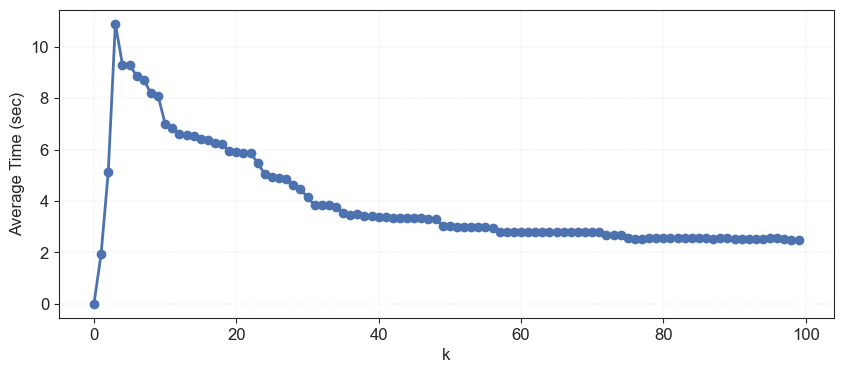

100%|██████████| 23/23 [00:32<00:00,  1.41s/it]


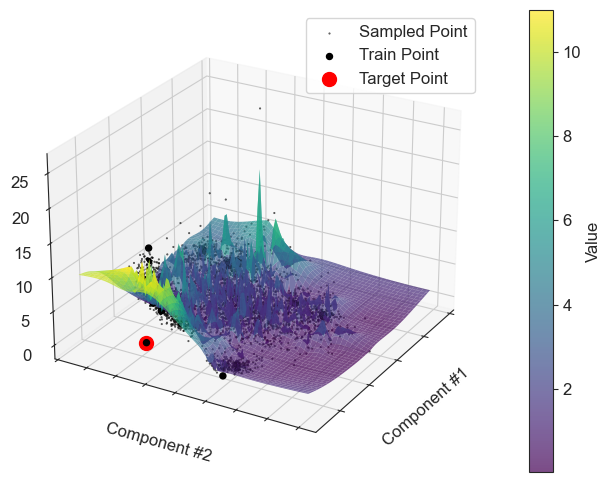

In [98]:
TIMEOUTED_AND_OVERESTIMATED_IDX = 5177
target_v, target_e, target_embedding, target_y = train_df.loc[TIMEOUTED_AND_OVERESTIMATED_IDX][["vertices", "edges", "embedding", "time"]]
support_points, all_distances = get_k_support_points_and_all_distances(target_embedding, train_dataloader, k=100)

for d, v, e, f, t, p, emb in sorted(support_points, key=lambda x: x[0])[:10]:
    print(f"distance {d:0.3f} | real time {t:0.3f} | prediction {p:0.3f} | is_dirty={is_dirty(v, e)}")
plot_avg_knn_times(support_points)

TIMEOUTED_AND_OVERESTIMATED_ARGS = prepare_args_for_3d_plot(
    TIMEOUTED_AND_OVERESTIMATED_IDX, train_df, 20, 100, noise_level=.1
)

plot_3d_surface(
    *TIMEOUTED_AND_OVERESTIMATED_ARGS, 
    elev=25, azim=30, figsize=(12, 6), softplus_rescale=False, 
    with_auxilary_points=True, projector=PCA, save_name="train_timeouted_overestimated.svg"
)

In [59]:
print(f"Execution time of default plan is ~{job_oracle.get_execution_time(OracleRequest(query_name='30c', hintset=0, dop=1)) / 1000:0.3f} sec")
print("Queries and parameters that lead to target plan (query, hs, dop):")
[(q_n, hs, dop) for q_n, hs, dop, t in get_query_info(*preprocess(target_v, target_e), TRAIN_VE_TO_TIMES, TRAIN_VET_TO_QUERY_INFO, job_oracle)]

Execution time of default plan is ~0.001 sec
Queries and parameters that lead to target plan (query, hs, dop):


[('30c', 56, 1), ('30c', 124, 1), ('30c', 60, 1), ('30c', 120, 1)]

Note that the actual execution time for this query is ~14sec. This means that our processning `T/O` indeed led to **underestimation of the label** and this, in turn, created the situation above - next to the large labels we plan with a highly underestimated time. In fact, we can even say that overestimating such a label is a natural behaviour - because other similar queries clearly show that certain patterns from the plan are signals of slow performance.

### Statement #2: in some regions the landscape is sharp by the nature of the task

The very nature of the dependence under study may cause situations when fast queries are located with relatively long queries, which makes the task of approximating surface difficult. In the extreme case where plans are completely same, we called this phenomenon collision. Although we have already simplified the problem in WeightedDataset by handling all collisions, a weaker version of this phenomenon is still observed in the data - we have similar plans whose labels are significantly different.

In [60]:
train_df.loc[
    ((train_df["prediction_category"] == "overestimated") & (train_df["is_dirty"] == False)),
    ["mape", "time", "prediction", "frequency", "time_category", "is_dirty", "abs_error"],
].sort_values(by=["mape"], ascending=False).head()

,mape,time,prediction,frequency,time_category,is_dirty,abs_error
3417,1710.683753,0.000611,1.045228,2,small,False,1.044617
1819,1037.120996,0.000882,0.914741,2,small,False,0.913859
655,978.259223,0.000752,0.735651,4,small,False,0.734899
5205,970.639141,0.000446,0.432905,4,small,False,0.432459
595,958.349753,0.000796,0.762846,2,small,False,0.762050


100%|██████████| 23/23 [00:29<00:00,  1.28s/it]

distance 0.000 | real time 0.001 | prediction 1.045 | is_dirty=False
distance 0.080 | real time 1.626 | prediction 0.859 | is_dirty=False
distance 0.204 | real time 9.867 | prediction 6.071 | is_dirty=False
distance 0.212 | real time 4.610 | prediction 4.961 | is_dirty=False
distance 0.214 | real time 5.847 | prediction 7.256 | is_dirty=False
distance 0.214 | real time 7.265 | prediction 7.187 | is_dirty=False
distance 0.219 | real time 5.131 | prediction 7.192 | is_dirty=False
distance 0.226 | real time 0.001 | prediction 9.114 | is_dirty=True
distance 0.229 | real time 0.000 | prediction 0.148 | is_dirty=False
distance 0.233 | real time 5.492 | prediction 6.124 | is_dirty=False


<Figure size 1000x400 with 0 Axes>

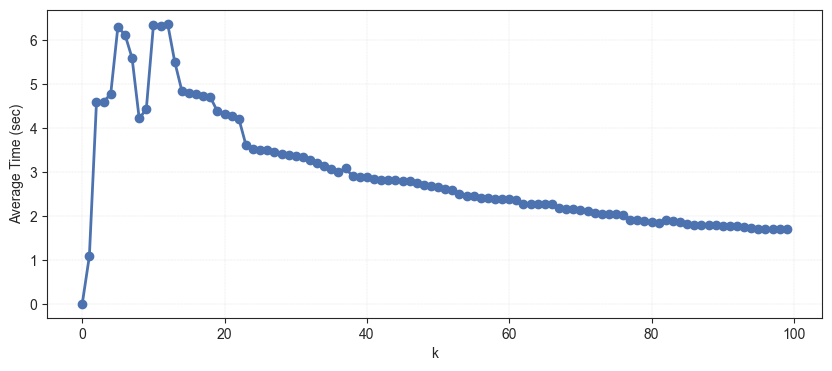

100%|██████████| 23/23 [00:30<00:00,  1.31s/it]


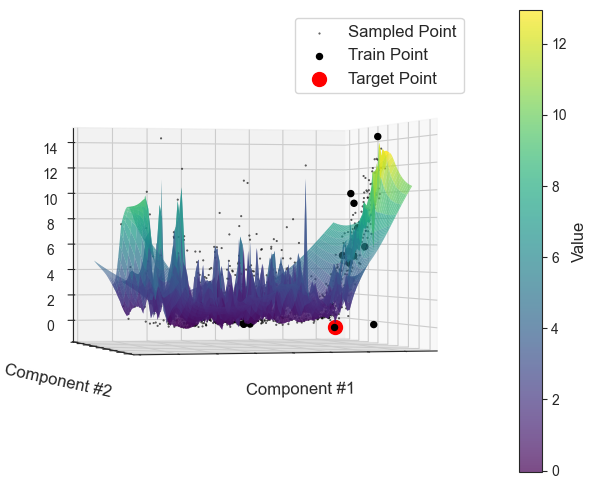

In [61]:
MOST_OVERESTIMATED_IDX = 3417
target_v, target_e, target_embedding, target_y = train_df.loc[MOST_OVERESTIMATED_IDX][["vertices", "edges", "embedding", "time"]]
support_points, all_distances = get_k_support_points_and_all_distances(target_embedding, train_dataloader, k=100)

for d, v, e, f, t, p, emb in sorted(support_points, key=lambda x: x[0])[:10]:
    print(f"distance {d:0.3f} | real time {t:0.3f} | prediction {p:0.3f} | is_dirty={is_dirty(v, e)}")
plot_avg_knn_times(support_points)

MOST_OVERESTIMATED_ARGS = prepare_args_for_3d_plot(
    MOST_OVERESTIMATED_IDX, train_df, 15, 20, noise_level=1
)

plot_3d_surface(
    *MOST_OVERESTIMATED_ARGS, 
    elev=0, azim=75, figsize=(12, 6), softplus_rescale=False, 
    with_auxilary_points=True, projector=PCA, save_name="train_overestimated.svg"
)

**Conclusions.**\
Everything appears as though the smoothness of the surface approximated by NN leads to a situation where points on the slopes of a sharp peak are underestimated in order to “catch up” and approach a sufficiently small value at its base. And due to the struggle of three forces - a) needing a sufficiently large value at the peak, b) not too small on the slope, b) and very small at the elevation, we end up with underestimation and overestimation in the latter two cases, respectively.

P.S. it is also difficult to quickly ‘descend’ from such hills because the dynamics of weight changes in the ‘lowlands’ is strongly slowed down due to the gradient (more on this later).

### Statement #3: the dynamics of learning at points with small predictions is difficult by itself

To make the predictions positive and at the same time be able to get feedback from small predictions during back propagation, we decided to add activation at the end of the NN and chose the softplus layer instead of relu. But this has consequences - the derivative of the softplus layer for small predictions is very small, so the learning speed in these areas may lead to overestimates.

In [62]:
train_df.loc[
    ((train_df["prediction_category"] == "overestimated") & (train_df["is_dirty"] == False)),
    ["mape", "time", "prediction", "frequency", "time_category", "prediction_category", "embedding", "is_dirty", "abs_error"]
].sort_values(by=["mape"], ascending=False)[:10]

,mape,time,prediction,frequency,time_category,prediction_category,embedding,is_dirty,abs_error
3417,1710.683753,0.000611,1.045228,2,small,overestimated,"[tensor(-0.0055), tensor(-0.0206), tensor(-0.0...",False,1.044617
1819,1037.120996,0.000882,0.914741,2,small,overestimated,"[tensor(-0.0055), tensor(-0.0206), tensor(-0.0...",False,0.913859
655,978.259223,0.000752,0.735651,4,small,overestimated,"[tensor(-0.0055), tensor(-0.0206), tensor(0.19...",False,0.734899
5205,970.639141,0.000446,0.432905,4,small,overestimated,"[tensor(-0.0055), tensor(-0.0206), tensor(0.02...",False,0.432459
595,958.349753,0.000796,0.762846,2,small,overestimated,"[tensor(-0.0055), tensor(0.3972), tensor(0.173...",False,0.762050
4778,806.998872,0.000237,0.190990,30,small,overestimated,"[tensor(-0.0055), tensor(-0.0206), tensor(-0.0...",False,0.190753
3879,799.960632,0.001062,0.849558,2,small,overestimated,"[tensor(-0.0055), tensor(-0.0206), tensor(-0.0...",False,0.848496
4547,770.851402,0.000412,0.317591,4,small,overestimated,"[tensor(-0.0055), tensor(-0.0206), tensor(-0.0...",False,0.317179
889,746.677250,0.000587,0.438300,2,small,overestimated,"[tensor(-0.0055), tensor(-0.0206), tensor(1.31...",False,0.437713
1858,744.089816,0.000721,0.536489,1,small,overestimated,"[tensor(-0.0055), tensor(-0.0206), tensor(-0.0...",False,0.535768


100%|██████████| 23/23 [00:31<00:00,  1.37s/it]

distance 0.000 | real time 0.000 | prediction 0.191 | is_dirty=False
distance 0.101 | real time 0.000 | prediction 0.150 | is_dirty=False
distance 0.218 | real time 0.754 | prediction 0.873 | is_dirty=True
distance 0.233 | real time 0.001 | prediction 0.145 | is_dirty=False
distance 0.243 | real time 0.754 | prediction 0.745 | is_dirty=True
distance 0.255 | real time 0.754 | prediction 0.824 | is_dirty=True
distance 0.255 | real time 0.001 | prediction 0.213 | is_dirty=False
distance 0.257 | real time 0.001 | prediction 0.112 | is_dirty=False
distance 0.261 | real time 0.001 | prediction 0.112 | is_dirty=False
distance 0.263 | real time 0.001 | prediction 0.095 | is_dirty=False


<Figure size 1000x400 with 0 Axes>

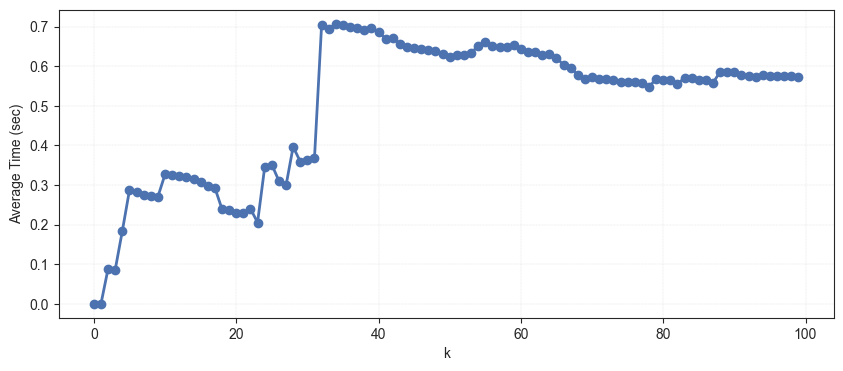

100%|██████████| 23/23 [00:32<00:00,  1.43s/it]


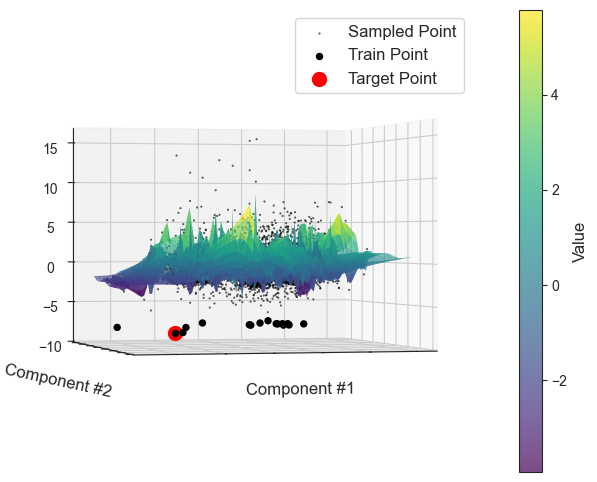

In [63]:
FREQUENT_AND_OVERESTIMATED_IDX = 4778
target_v, target_e, target_embedding, target_y = train_df.loc[FREQUENT_AND_OVERESTIMATED_IDX][["vertices", "edges", "embedding", "time"]]
support_points, all_distances = get_k_support_points_and_all_distances(target_embedding, train_dataloader, k=100)

for d, v, e, f, t, p, emb in sorted(support_points, key=lambda x: x[0])[:10]:
    print(f"distance {d:0.3f} | real time {t:0.3f} | prediction {p:0.3f} | is_dirty={is_dirty(v, e)}")
plot_avg_knn_times(support_points)

FREQUENT_AND_OVERESTIMATED_ARGS = prepare_args_for_3d_plot(
    FREQUENT_AND_OVERESTIMATED_IDX, train_df, 20, 100, noise_level=.1
)

plot_3d_surface(
    *FREQUENT_AND_OVERESTIMATED_ARGS, 
    elev=0, azim=75, figsize=(12, 6), softplus_rescale=True, 
    with_auxilary_points=True, projector=PCA, save_name="train_frequent_overestimated.svg"
)

Note - we visualized the dependency before including the final `softplus` layer 

$$y := \text{NN}(x) = \text{softplus}(\text{FCNN}(\text{BTCNN}(x)))$$
$$\hat{y} := \text{FCNN}(\text{BTCNN}(x)), \text{ i.e. } y = \text{softplus}(\hat{y})$$

This visualization revealed difficulties in predicting small values across most scenarios, likely due to this last layer. Specifically, the derivative of the `softplus` is $\frac{1}{1+e^{-\hat{y}}}$, and when predicting $y \approx 0.2$, $\hat{y}$ values close to 2.5. So, in that regions the gradient is reduced in **>10 times**. Consequently, with a small `lr` in the later stages of training, it becomes **challenging to adjust weights effectively** in such demanding areas.

## Validation Data

**Observation:**

$metric\vert_{train} \ll metric\vert_{val}$ for **ANY** metric on **ANY** subset

Is seems that there's no possiblity for complete generalization. Cause of that complex dependency between plans and times it may be impossible to correctly interpolate knowledge.

In [64]:
filter_metrics_df(aggregated_metrics_df, ["train"], ["all"], ["all"], None, None)

,data_type,structure_category,tree_category,time_category,prediction_category,size,mse,mape
0,train,all,all,all,all,34914,0.059±0.007,12.504±2.044
1,train,all,all,all,underestimated,13572,0.071±0.011,0.196±0.042
2,train,all,all,all,overestimated,21342,0.054±0.010,20.911±4.650
3,train,all,all,small,all,8627,0.035±0.017,50.396±8.729
4,train,all,all,small,underestimated,2384,0.004±0.000,0.427±0.035
5,train,all,all,small,overestimated,6243,0.048±0.024,69.509±11.587
6,train,all,all,medium,all,17412,0.034±0.005,0.144±0.015
7,train,all,all,medium,underestimated,7787,0.043±0.013,0.196±0.040
8,train,all,all,medium,overestimated,9625,0.030±0.005,0.111±0.006
9,train,all,all,big,all,8875,0.132±0.011,0.014±0.001


In [65]:
filter_metrics_df(aggregated_metrics_df, ["val"], ["all"], ["all"], None, None)

,data_type,structure_category,tree_category,time_category,prediction_category,size,mse,mape
108,val,all,all,all,all,8478,33.457±8.367,43.153±6.778
109,val,all,all,all,underestimated,4015,53.316±16.079,0.325±0.025
110,val,all,all,all,overestimated,4463,16.180±3.994,82.101±14.492
111,val,all,all,small,all,1931,6.721±5.113,188.509±34.818
112,val,all,all,small,underestimated,552,0.004±0.000,0.466±0.043
113,val,all,all,small,overestimated,1379,9.184±6.707,261.504±36.343
114,val,all,all,medium,all,4260,5.379±1.909,0.967±0.177
115,val,all,all,medium,underestimated,2103,0.538±0.136,0.324±0.021
116,val,all,all,medium,overestimated,2157,10.098±3.636,1.611±0.397
117,val,all,all,big,all,2287,109.578±30.464,0.245±0.007


### Statement #4: the sharpness of the landscape is one of the challenges in generalisation

Probably most often errors are reached in the "peaks" before mountains with the transition of fast queries to long queries.

In [66]:
val_df = load_run_and_get_filtered_df(1, "val", "all", "all", "all", "all")
val_df["abs_error"] = val_df["error"].abs()
val_df["mape"] = val_df["prediction"] / val_df["time"] .abs()
val_df["is_dirty"] = val_df.apply(lambda row: is_dirty(*preprocess(row["vertices"], row["edges"])), axis=1)

**most overestimated**

In [67]:
val_df.loc[
    (val_df["is_dirty"] == False) & (val_df["prediction_category"] == "overestimated"),
    ["abs_error", "time", "prediction", "frequency", "time_category", "prediction_category", "embedding", "is_dirty", "mape"]
].sort_values(by="abs_error", ascending=False).head()

,abs_error,time,prediction,frequency,time_category,prediction_category,embedding,is_dirty,mape
6182,15.486683,2.992474,18.479156,16,medium,overestimated,"[tensor(-0.0055), tensor(-0.0206), tensor(-0.0...",False,6.175211
6322,10.896066,0.642389,11.538455,8,medium,overestimated,"[tensor(-0.0055), tensor(-0.0206), tensor(-0.0...",False,17.961801
6501,9.670116,2.615051,12.285167,4,medium,overestimated,"[tensor(-0.0055), tensor(-0.0206), tensor(0.12...",False,4.697869
6056,8.125561,53.265110,61.390671,8,big,overestimated,"[tensor(-0.0055), tensor(-0.0206), tensor(0.34...",False,1.152549
6839,7.445187,19.741898,27.187084,6,big,overestimated,"[tensor(-0.0055), tensor(-0.0206), tensor(-0.0...",False,1.377126


100%|██████████| 23/23 [00:35<00:00,  1.53s/it]

distance 0.271 | real time 22.663 | prediction 22.858 | is_dirty=True
distance 0.304 | real time 5.478 | prediction 5.542 | is_dirty=True
distance 0.310 | real time 5.041 | prediction 5.067 | is_dirty=True
distance 0.345 | real time 32.400 | prediction 32.523 | is_dirty=True
distance 0.412 | real time 7.234 | prediction 7.391 | is_dirty=True
distance 0.436 | real time 11.355 | prediction 11.513 | is_dirty=False
distance 0.462 | real time 8.506 | prediction 8.664 | is_dirty=True
distance 0.469 | real time 2.086 | prediction 2.110 | is_dirty=True
distance 0.489 | real time 10.486 | prediction 10.606 | is_dirty=False
distance 0.509 | real time 3.749 | prediction 3.755 | is_dirty=True


<Figure size 1000x400 with 0 Axes>

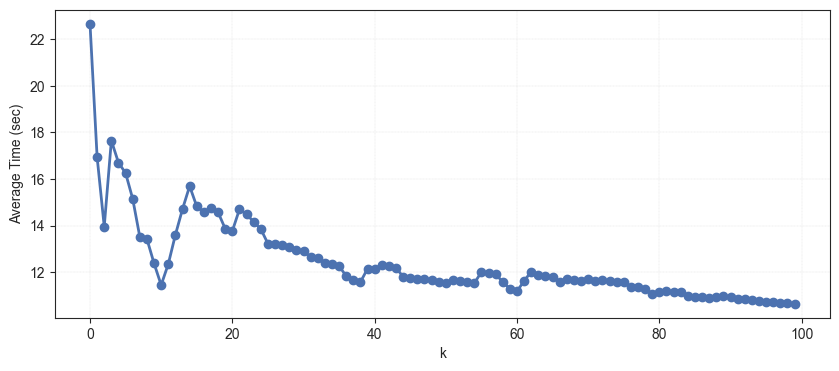

100%|██████████| 23/23 [00:34<00:00,  1.51s/it]


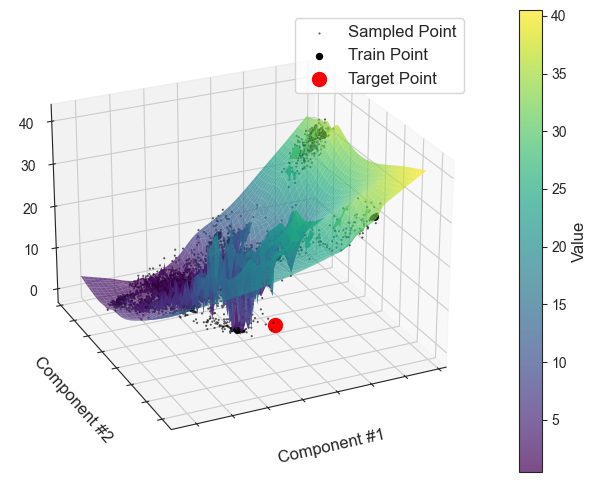

In [68]:
MOST_OVERESTIMATED_IDX = 6182
target_v, target_e, target_embedding, target_y = val_df.loc[MOST_OVERESTIMATED_IDX][["vertices", "edges", "embedding", "time"]]
support_points, all_distances = get_k_support_points_and_all_distances(target_embedding, train_dataloader, k=100)

for d, v, e, f, t, p, emb in sorted(support_points, key=lambda x: x[0])[:10]:
    print(f"distance {d:0.3f} | real time {t:0.3f} | prediction {p:0.3f} | is_dirty={is_dirty(v, e)}")
plot_avg_knn_times(support_points)

MOST_OVERESTIMATED_ARGS = prepare_args_for_3d_plot(
    MOST_OVERESTIMATED_IDX, val_df, 20, 100, noise_level=.1
)

plot_3d_surface(
    *MOST_OVERESTIMATED_ARGS, 
    elev=25, azim=65, figsize=(12, 6), softplus_rescale=False, 
    with_auxilary_points=True, projector=PCA, save_name="val_overestimated.svg"
)

**Conclusions.**\
We see, that many close plans are slow and `T/O`ed, and learned landscape isn't sharp enough to predict so small value (3sec) on the slope. In fact, the neural network had no information that this peak was so sharp, **so its behaviour is completely justified by the train data**.

**most underestimated**

In [69]:
val_df.loc[
    (val_df["is_dirty"] == False) & (val_df["prediction_category"] == "underestimated"),
    ["abs_error", "time", "prediction", "frequency", "time_category", "prediction_category", "embedding", "is_dirty", "mape"]
].sort_values(by="abs_error", ascending=False).head()

,abs_error,time,prediction,frequency,time_category,prediction_category,embedding,is_dirty,mape
6291,51.543720,99.418854,47.875134,4,big,underestimated,"[tensor(-0.0055), tensor(-0.0206), tensor(0.06...",False,0.481550
6905,32.316675,32.359970,0.043295,2,big,underestimated,"[tensor(-0.0055), tensor(-0.0206), tensor(-0.0...",False,0.001338
7160,32.127347,32.136410,0.009063,2,big,underestimated,"[tensor(-0.0055), tensor(-0.0206), tensor(-0.0...",False,0.000282
7182,32.090003,32.397373,0.307371,4,big,underestimated,"[tensor(-0.0055), tensor(0.1369), tensor(-0.03...",False,0.009488
5944,30.542945,31.674522,1.131577,2,big,underestimated,"[tensor(-0.0055), tensor(-0.0206), tensor(-0.0...",False,0.035725


100%|██████████| 23/23 [00:35<00:00,  1.54s/it]

distance 0.373 | real time 53.171 | prediction 53.190 | is_dirty=False
distance 0.376 | real time 73.216 | prediction 73.450 | is_dirty=False
distance 0.378 | real time 72.767 | prediction 73.142 | is_dirty=False
distance 0.380 | real time 72.891 | prediction 73.170 | is_dirty=False
distance 0.380 | real time 72.992 | prediction 73.489 | is_dirty=False
distance 0.383 | real time 70.447 | prediction 70.441 | is_dirty=False
distance 0.384 | real time 69.923 | prediction 70.173 | is_dirty=False
distance 0.385 | real time 72.969 | prediction 73.249 | is_dirty=False
distance 0.385 | real time 73.116 | prediction 73.341 | is_dirty=False
distance 0.386 | real time 69.747 | prediction 70.149 | is_dirty=False


<Figure size 1000x400 with 0 Axes>

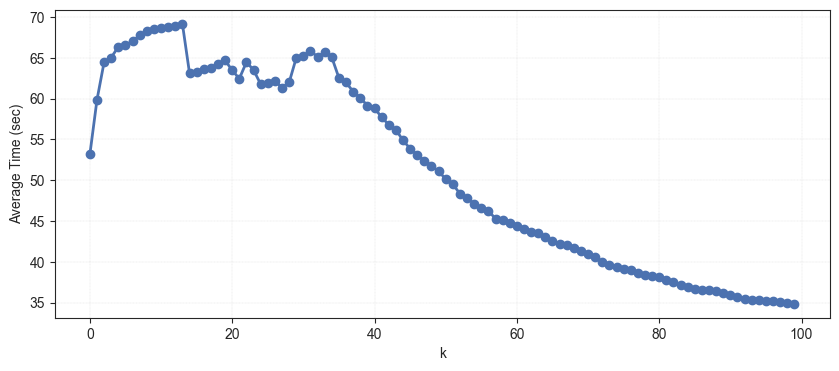

100%|██████████| 23/23 [00:34<00:00,  1.51s/it]


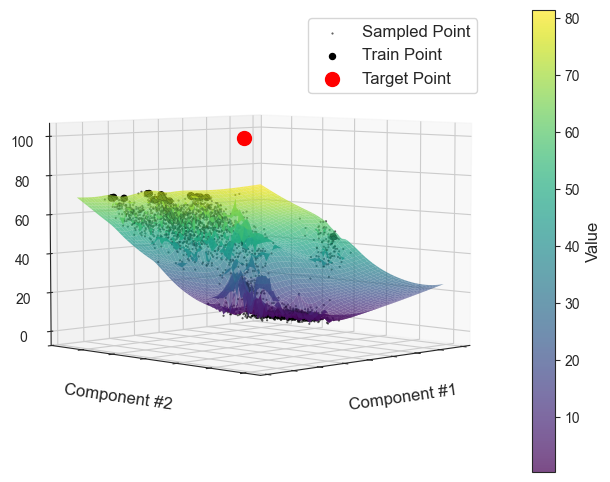

In [70]:
MOST_UNDERESTIMATED_IDX = 6291
target_v, target_e, target_embedding, target_y = val_df.loc[MOST_UNDERESTIMATED_IDX][["vertices", "edges", "embedding", "time"]]
support_points, all_distances = get_k_support_points_and_all_distances(target_embedding, train_dataloader, k=100)

for d, v, e, f, t, p, emb in sorted(support_points, key=lambda x: x[0])[:10]:
    print(f"distance {d:0.3f} | real time {t:0.3f} | prediction {p:0.3f} | is_dirty={is_dirty(v, e)}")
plot_avg_knn_times(support_points)

MOST_UNDERESTIMATED_ARGS = prepare_args_for_3d_plot(
    MOST_UNDERESTIMATED_IDX, val_df, 20, 100, noise_level=.1
)

plot_3d_surface(
    *MOST_UNDERESTIMATED_ARGS, 
    elev=5, azim=45, figsize=(12, 6), softplus_rescale=False, 
    with_auxilary_points=True, projector=PCA, save_name="val_underestimated.svg"
)

**Conclusions.**\
We see, there're just no points with such big execution time in train data, so **NN virtually hadn't opportunity to predict that**.

### Statement #5: tree structure helps in generalization
We can see that $metric\vert_{seen\_tree} \ll metric\vert_{unseen\_tree}$ for **ANY** metric on **ANY** subset, i.e. tree stucture helps NN in generalization.

In [71]:
filter_metrics_df(aggregated_metrics_df, ["val"], ["seen"], ["all"], None, None)

,data_type,structure_category,tree_category,time_category,prediction_category,size,mse,mape
144,val,seen,all,all,all,5393,20.042±8.179,21.217±6.292
145,val,seen,all,all,underestimated,2598,33.430±16.663,0.280±0.040
146,val,seen,all,all,overestimated,2796,7.616±3.491,40.605±12.021
147,val,seen,all,small,all,1160,5.792±6.671,96.524±27.096
148,val,seen,all,small,underestimated,357,0.004±0.001,0.441±0.058
149,val,seen,all,small,overestimated,803,7.705±8.865,137.274±34.084
150,val,seen,all,medium,all,2668,2.649±1.056,0.554±0.123
151,val,seen,all,medium,underestimated,1358,0.385±0.245,0.291±0.034
152,val,seen,all,medium,overestimated,1311,4.904±2.242,0.830±0.270
153,val,seen,all,big,all,1565,61.327±28.291,0.173±0.023


In [72]:
filter_metrics_df(aggregated_metrics_df, ["val"], ["unseen"], ["all"], None, None)

,data_type,structure_category,tree_category,time_category,prediction_category,size,mse,mape
180,val,unseen,all,all,all,3084,56.986±9.103,81.318±23.527
181,val,unseen,all,all,underestimated,1417,90.016±19.812,0.406±0.036
182,val,unseen,all,all,overestimated,1667,30.314±12.690,151.563±48.032
183,val,unseen,all,small,all,771,7.887±4.068,323.084±95.537
184,val,unseen,all,small,underestimated,195,0.004±0.001,0.492±0.088
185,val,unseen,all,small,overestimated,576,10.593±5.517,428.537±115.887
186,val,unseen,all,medium,all,1592,10.096±4.216,1.668±0.428
187,val,unseen,all,medium,underestimated,745,0.815±0.181,0.386±0.015
188,val,unseen,all,medium,overestimated,846,18.455±7.622,2.847±0.878
189,val,unseen,all,big,all,722,214.595±38.448,0.398±0.048


### Statement #6 (from `learning_dynamic.ipynb`): statistics are more descriptive feature than tree structure

This is not surprising, as statistics already include data size information, which is crucial for time prediction. Essentially, the neural network should act as a global cost model in this scenario. When information about the tree structure is available, it can transform into a contextual cost model, adjusting global cost parameters based on the specific case.

## Test Data

**(interesting!) Observation:**

$metric\vert_{test} \ll metric\vert_{val}$ for almost **ANY** metric on **ANY** subset

Probably, on average, the data in the test is similar to a huge number of queries from the train, and with any split, most of it is well represented.

In [73]:
filter_metrics_df(aggregated_metrics_df, ["test"], ["all"], ["all"], None, None)

,data_type,structure_category,tree_category,time_category,prediction_category,size,mse,mape
216,test,all,all,all,all,4992,26.464±15.335,11.701±2.611
217,test,all,all,all,underestimated,1953,53.563±36.062,0.137±0.014
218,test,all,all,all,overestimated,3039,8.981±5.418,19.300±4.949
219,test,all,all,small,all,1766,3.187±2.266,32.815±7.327
220,test,all,all,small,underestimated,171,0.001±0.000,0.356±0.119
221,test,all,all,small,overestimated,1595,3.520±2.503,36.324±7.905
222,test,all,all,medium,all,1238,0.750±0.961,0.287±0.079
223,test,all,all,medium,underestimated,672,0.169±0.111,0.193±0.037
224,test,all,all,medium,overestimated,566,1.728±2.708,0.425±0.186
225,test,all,all,big,all,1988,63.155±37.267,0.054±0.002


In [74]:
filter_metrics_df(aggregated_metrics_df, ["val"], ["all"], ["all"], None, None)

,data_type,structure_category,tree_category,time_category,prediction_category,size,mse,mape
108,val,all,all,all,all,8478,33.457±8.367,43.153±6.778
109,val,all,all,all,underestimated,4015,53.316±16.079,0.325±0.025
110,val,all,all,all,overestimated,4463,16.180±3.994,82.101±14.492
111,val,all,all,small,all,1931,6.721±5.113,188.509±34.818
112,val,all,all,small,underestimated,552,0.004±0.000,0.466±0.043
113,val,all,all,small,overestimated,1379,9.184±6.707,261.504±36.343
114,val,all,all,medium,all,4260,5.379±1.909,0.967±0.177
115,val,all,all,medium,underestimated,2103,0.538±0.136,0.324±0.021
116,val,all,all,medium,overestimated,2157,10.098±3.636,1.611±0.397
117,val,all,all,big,all,2287,109.578±30.464,0.245±0.007


It led us to the next discovery:

### Statement #7: **sub**structures are also important for generalisation

In [75]:
aggregated_neighborhoods_df[aggregated_neighborhoods_df["data_type"] == "val"]

,height,data_type,match_probability
0,1,val,0.853±0.005
2,2,val,0.723±0.006
4,3,val,0.621±0.006
6,4,val,0.527±0.005


In [76]:
aggregated_neighborhoods_df[aggregated_neighborhoods_df["data_type"] == "test"]

,height,data_type,match_probability
1,1,test,0.975±0.006
3,2,test,0.952±0.009
5,3,test,0.933±0.011
7,4,test,0.914±0.013


**Conclusions.**\
We see that, on average, the probability of encountering subtrees of height 1-4 in the test is significantly higher. This must have a positive effect on the borrowing of knowledge from the train and allows for better prediction on the test.

Note that there is no point in considering trees of greater height - as we only use 4 tree convolutional layers.

## OOD Data

**(interesting!) Observation:**

$mse\vert_{underestimated} \ll mse\vert_{overestimated}$

i.e. the main problem with `ood` data is huge underestimation of super-long queries.

In [77]:
filter_metrics_df(aggregated_metrics_df, ["ood"], ["all"], ["all"], ["all"], ["all"])

,data_type,structure_category,tree_category,time_category,prediction_category,size,mse,mape
324,ood,all,all,all,all,10368,4667.407±19.365,53.862±8.175


In [78]:
filter_metrics_df(aggregated_metrics_df, ["ood"], ["all"], ["all"], ["big"], None)

,data_type,structure_category,tree_category,time_category,prediction_category,size,mse,mape
333,ood,all,all,big,all,8825,5482.100±23.081,0.899±0.008
334,ood,all,all,big,underestimated,8713,5551.447±30.842,0.901±0.008
335,ood,all,all,big,overestimated,112,92.529±53.798,0.755±0.211


In [79]:
filter_metrics_df(aggregated_metrics_df, ["ood"], ["all"], ["all"], ["medium"], None)

,data_type,structure_category,tree_category,time_category,prediction_category,size,mse,mape
330,ood,all,all,medium,all,1052,6.946±0.930,1.043±0.078
331,ood,all,all,medium,underestimated,950,4.885±0.297,0.799±0.029
332,ood,all,all,medium,overestimated,102,25.891±6.693,3.337±0.681


In [80]:
filter_metrics_df(aggregated_metrics_df, ["ood"], ["all"], ["all"], ["small"], None)

,data_type,structure_category,tree_category,time_category,prediction_category,size,mse,mape
327,ood,all,all,small,all,491,9.840±7.754,1118.974±172.814
328,ood,all,all,small,underestimated,1,0.002±0.002,0.238±0.306
329,ood,all,all,small,overestimated,490,9.849±7.749,1120.806±172.872


### Statement #8: if there is a shift in the time distribution, the model loses the ability to generalise

We have already seen how underestimation of multiple long queries significantly increases MSE on the val data. In the case of ood, this situation becomes even more acute - we have a larger number of long queries in general, which in addition have a unseen tree structure. All this leads to the fact that training on ood data is almost non-existent.

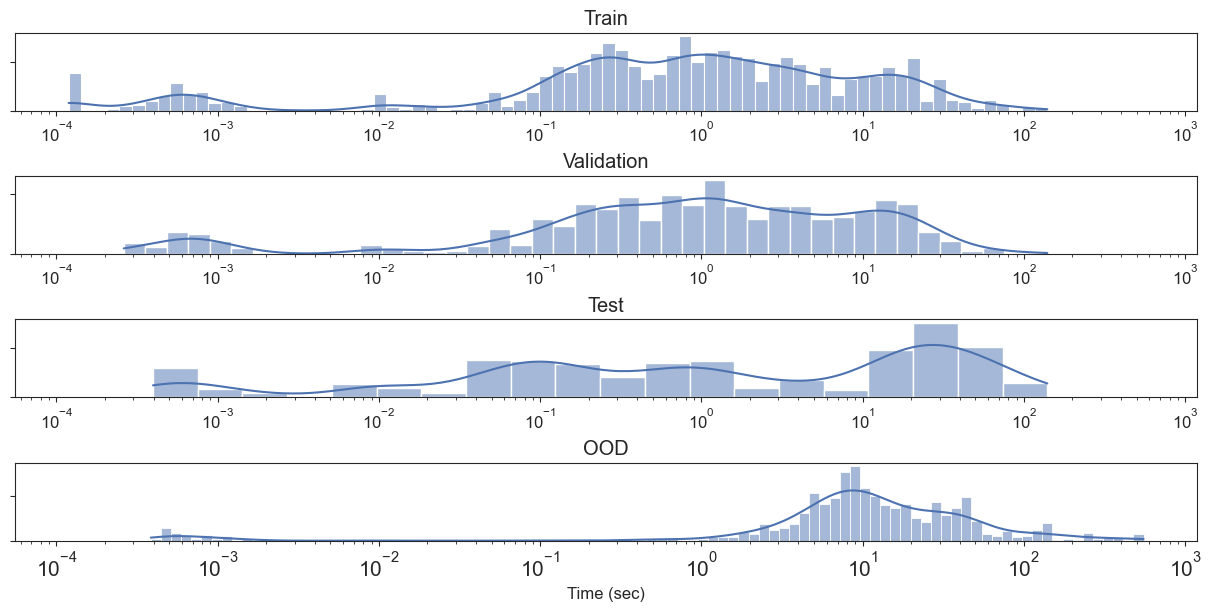

In [81]:
train_times = [el[3].to("cpu").item() for el in train_dataset for _ in range(el[2])]
val_times = [el[3].to("cpu").item() for el in val_dataset for _ in range(el[2])]

test_times = [el[3].to("cpu").item() for el in test_dataset for _ in range(el[2])]
ood_times = [el[3].to("cpu").item() for el in ood_dataset for _ in range(el[2])]

plot_times(train_times, test_times, val_times, ood_times, save_name="time_distribution.svg")

### Statement 9: correlation between prediction and execution time for NN is better than for Cost Model on `val` and `test` samples, but loses on `ood`

Experiments with noised data have shown us that NN probably plays the role of a cost-corrector (where the unit of cost is time). Hence, we wonder - in the most ‘inconvenient’ case on `ood` data, even if the exact time cannot be predicted, which predictions are better to trust - from NN or from Planner?

P.S. hint mechanism uses **cost corruption** (at least in `@OpenGauss` and `@PostgreSQL`), so the cost model should be better at the normal planning stage.

In [ ]:
n_runs = 5
correlations_dict = calculate_stratified_correlations(n_runs)
correlations_df = aggregate_correlations_dict(correlations_dict,  range(1, n_runs+1))
# pd.read_csv(f"{ARTIFACTS_PATH}/correlations_df.csv")

In [87]:
select_subdf(correlations_df, ["train"], ["all"], ["all"], None, ["all"])

,data_type,structure_category,tree_category,time_category,prediction_category,size,Kendall [c],Kendall [p],Spearman [c],Spearman [p]
0,train,all,all,all,all,34914,0.199±0.005,0.895±0.007,0.277±0.008,0.974±0.003
3,train,all,all,small,all,8627,0.104±0.009,0.376±0.027,0.145±0.013,0.537±0.033
6,train,all,all,medium,all,17412,0.172±0.007,0.859±0.012,0.250±0.010,0.959±0.005
9,train,all,all,big,all,8875,0.121±0.007,0.930±0.005,0.179±0.010,0.985±0.003


In [88]:
select_subdf(correlations_df, ["val"], ["all"], ["all"], None, ["all"])

,data_type,structure_category,tree_category,time_category,prediction_category,size,Kendall [c],Kendall [p],Spearman [c],Spearman [p]
108,val,all,all,all,all,8477,0.153±0.024,0.723±0.019,0.213±0.034,0.865±0.016
111,val,all,all,small,all,1931,-0.002±0.047,0.196±0.065,-0.026±0.073,0.290±0.088
114,val,all,all,medium,all,4260,0.169±0.030,0.552±0.038,0.245±0.041,0.704±0.041
117,val,all,all,big,all,2286,0.095±0.026,0.598±0.031,0.145±0.035,0.720±0.035


In [89]:
select_subdf(correlations_df, ["test"], ["all"], ["all"], None, ["all"])

,data_type,structure_category,tree_category,time_category,prediction_category,size,Kendall [c],Kendall [p],Spearman [c],Spearman [p]
216,test,all,all,all,all,4992,0.061±0.000,0.856±0.009,0.076±0.000,0.954±0.006
219,test,all,all,small,all,1766,-0.044±0.000,0.394±0.026,-0.081±0.000,0.574±0.036
222,test,all,all,medium,all,1238,0.205±0.000,0.764±0.038,0.276±0.000,0.882±0.033
225,test,all,all,big,all,1988,0.148±0.000,0.895±0.011,0.195±0.000,0.967±0.010


In [90]:
select_subdf(correlations_df, ["ood"], ["all"], ["all"], None, ["all"])

,data_type,structure_category,tree_category,time_category,prediction_category,size,Kendall [c],Kendall [p],Spearman [c],Spearman [p]
324,ood,all,all,all,all,10368,0.161±0.000,0.184±0.016,0.242±0.000,0.271±0.024
327,ood,all,all,small,all,491,0.396±0.000,0.221±0.052,0.545±0.000,0.325±0.075
330,ood,all,all,medium,all,1052,0.051±0.000,0.065±0.033,0.059±0.000,0.094±0.046
333,ood,all,all,big,all,8825,0.174±0.000,0.139±0.027,0.261±0.000,0.206±0.042


In [ ]:
metric_params = [
    ("trainval", job_list_info, job_oracle),
    ("test", id_sq_list_info, sq_oracle),
    ("ood", ood_sq_list_info, sq_oracle)
]

data = [(d, *get_per_query_correlations(range(1, 5+1), l, o)) for d, l, o in metric_params]
columns = ["data_type",  "Kendall [c]",  "Kendall [p]",  "Spearman [c]",  "Spearman [p]"]
per_query_correlations_df = pd.DataFrame(data, columns=columns)
per_query_correlations_df.to_csv(f"{ARTIFACTS_PATH}/per_query_correlations_df.csv", index=False)
# per_query_correlations_df = pd.read_csv(f"{ARTIFACTS_PATH}/per_query_correlations_df.csv")

In [99]:
per_query_correlations_df

,data_type,Kendall [c],Kendall [p],Spearman [c],Spearman [p]
0,trainval,0.435±0.000,0.634±0.010,0.585±0.000,0.765±0.010
1,test,0.468±0.000,0.588±0.005,0.615±0.000,0.724±0.006
2,ood,0.394±0.000,0.178±0.029,0.529±0.000,0.255±0.039


**Conclusions.**\
 The per-query analysis confirmed our fears that generalisation on `ood` data might be quite weak. We saw that mse hardly dropped at all on `ood` data, and the current results also show us that in comparing an arbitrary pair of plans for specific queries, on average, the cost model will perform better on `ood` data.

### Statement 10: NN can be used for solving Ranking Problem (except `ood` data)

Note, ranking problem is interesting for its own reason, because the ranking problem by its nature can be a bit easier than a regression problem - we do not care how much the model is wrong, the only thing that matters is that the correct order is restored. An example of such a problem is the ranking of neighbours in an iteration of a local search algorithm.

Here we plot the total execution time of queries after optimisation, which consists in the following: execute the top-k queries and store the best one, where the plans order will be induced either a) by cost predictions or b) by NN predictions.

Baseline is default planner with `dop` equal to 64. All calculations are made on data and model from the first split.

In [91]:
job_q_n_to_predictions_and_params, job_q_n_to_costs_and_params = get_estimations_and_params(1, job_oracle)
sq_q_n_to_predictions_and_params, sq_q_n_to_costs_and_params = get_estimations_and_params(1, sq_oracle)

In [92]:
trainval_queries = job_oracle.get_query_names()
test_queries, ood_queries = set(info["query_name"] for info in id_sq_list_info), set(info["query_name"] for info in ood_sq_list_info)
assert not test_queries & ood_queries

In [93]:
# split on `train`/`val` data is impossible because data has been splitted for training in per-plan way.
k_range = range(0, len(HINTSETS))
trainval_def, trainval_cost, trainval_pred = zip(*[get_e2e_performances(trainval_queries, job_oracle, job_q_n_to_costs_and_params, job_q_n_to_predictions_and_params, k) for k in k_range])
test_def, test_cost, test_pred = zip(*[get_e2e_performances(test_queries, sq_oracle, sq_q_n_to_costs_and_params, sq_q_n_to_predictions_and_params, k) for k in k_range])
ood_def, ood_cost, ood_pred = zip(*[get_e2e_performances(ood_queries, sq_oracle, sq_q_n_to_costs_and_params, sq_q_n_to_predictions_and_params, k) for k in k_range])

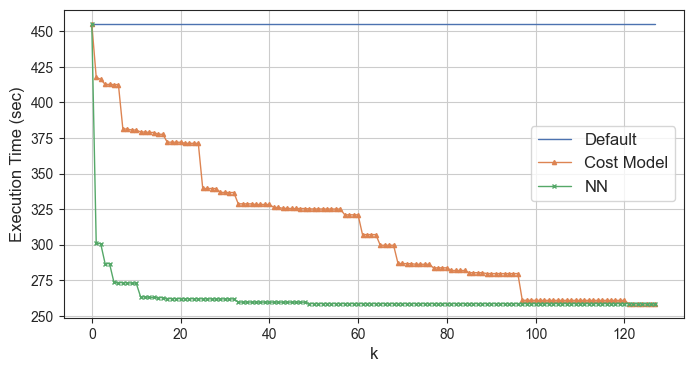

In [94]:
topk_plot(k_range, trainval_def, trainval_cost, trainval_pred, save_name="topk_performance_trainval.svg")

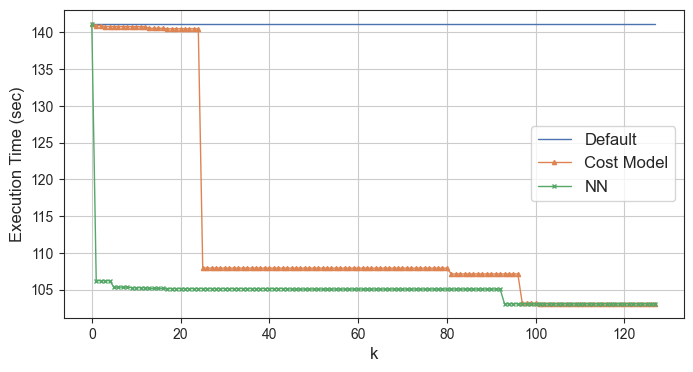

In [95]:
topk_plot(k_range, test_def, test_cost, test_pred, save_name="topk_performance_test.svg")

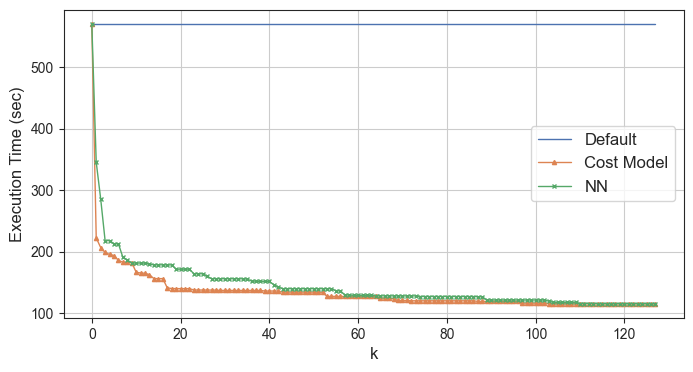

In [96]:
topk_plot(k_range, ood_def, ood_cost, ood_pred, save_name="topk_performance_ood.svg")

**Conclusions.** \
On `ood` data the NN performs slightly worse than the standard Cost Model, but on `train`, `val` and `test` data the predictions of the model are **significantly more efficient**. This allows us to hope that when solving the regression problem, the NN predictions can be successfully used to optimise queries at least for solving ranking problems.